In [36]:
### Baseline DELG global feature for retrieval ###

### Code Adaptived from the Original Kernal ###
### https://www.kaggle.com/camaskew/host-baseline-example?scriptVersionId=40287695

import os
import pandas as pd
import numpy as np
import PIL
from scipy import spatial
import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras import Model
import tensorflow.keras as keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input

In [4]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [37]:
INPUT_DIR = os.path.join('..', 'input')
DATASET_DIR = os.path.join(INPUT_DIR, 'landmark-retrieval-2021')
TEST_IMAGE_DIR = os.path.join(DATASET_DIR, 'test')
TRAIN_IMAGE_DIR = os.path.join(DATASET_DIR, 'index')

TOP_K = 100

# DELG model:
SAVED_MODEL_DIR = '../input/delg-saved-models/local_and_global'
#DELG_MODEL = tf.saved_model.load(SAVED_MODEL_DIR)
DELG_IMAGE_SCALES_TENSOR = tf.convert_to_tensor([0.70710677, 1.0, 1.4142135])
DELG_INPUT_TENSOR_NAMES = ['input_image:0', 'input_scales:0']

# Global feature extraction:
NUM_EMBEDDING_DIMENSIONS = 2048
model = keras.applications.VGG16(weights='imagenet', include_top=True)


In [38]:
def load_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

shape of x:  (1, 224, 224, 3)
data type:  float32


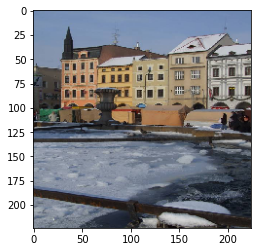

In [10]:
import matplotlib.pyplot as plt
img, x = load_image("../input/landmark-retrieval-2021/train/0/0/0/0000059611c7d079.jpg")
print("shape of x: ", x.shape)
print("data type: ", x.dtype)
plt.imshow(img)

In [39]:
predictions = model.predict(x)
for _, pred, prob in decode_predictions(predictions)[0]:
    print("predicted %s with probability %0.3f" % (pred, prob))

predicted palace with probability 0.445
predicted fountain with probability 0.188
predicted monastery with probability 0.049
predicted lakeside with probability 0.039
predicted patio with probability 0.037


In [12]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

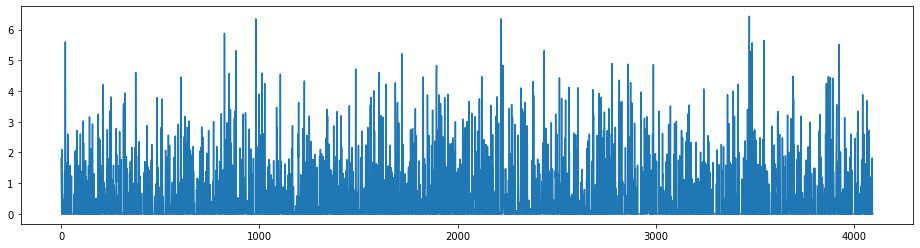

In [14]:
img, x = load_image("../input/landmark-retrieval-2021/train/0/0/0/0000059611c7d079.jpg")
feat = feat_extractor.predict(x)

plt.figure(figsize=(16,4))
plt.plot(feat[0])

In [33]:
images_path = '../input/landmark-retrieval-2021/train'
image_extensions = ['.jpg', '.png', '.jpeg']   # case-insensitive (upper/lower doesn't matter)
max_num_images = 10

images = []
for root, dirs, files in os.walk(TRAIN_IMAGE_DIR):
    for file in files:
        if file.endswith('.jpg'):
             images.append(os.path.join(root, file))
        
#images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
#if max_num_images < len(images):
    #images = [images[i] for i in sorted(random.sample(xrange(len(images)), max_num_images))]

print("keeping %d images to analyze" % len(images))

keeping 76176 images to analyze


In [41]:
import time
tic = time.clock()
features = []
for i, image_path in enumerate(images):
    if i % 500 == 0:
        toc = time.clock()
        elap = toc-tic;
        print("analyzing image %d / %d. Time: %4.4f seconds." % (i, len(images),elap))
        tic = time.clock()
    img, x = load_image(image_path);
    feat = feat_extractor.predict(x)[0]
    features.append(feat)

print('finished extracting features for %d images' % len(images))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if __name__ == '__main__':


analyzing image 0 / 76176. Time: 0.0007 seconds.
analyzing image 500 / 76176. Time: 22.2885 seconds.
analyzing image 1000 / 76176. Time: 21.9003 seconds.
analyzing image 1500 / 76176. Time: 22.4859 seconds.
analyzing image 2000 / 76176. Time: 22.1111 seconds.
analyzing image 2500 / 76176. Time: 22.6572 seconds.
analyzing image 3000 / 76176. Time: 22.1778 seconds.
analyzing image 3500 / 76176. Time: 22.7793 seconds.
analyzing image 4000 / 76176. Time: 22.8355 seconds.
analyzing image 4500 / 76176. Time: 22.2258 seconds.
analyzing image 5000 / 76176. Time: 22.1025 seconds.
analyzing image 5500 / 76176. Time: 22.3528 seconds.
analyzing image 6000 / 76176. Time: 22.9748 seconds.
analyzing image 6500 / 76176. Time: 22.6452 seconds.
analyzing image 7000 / 76176. Time: 22.3842 seconds.
analyzing image 7500 / 76176. Time: 22.6532 seconds.
analyzing image 8000 / 76176. Time: 22.2462 seconds.
analyzing image 8500 / 76176. Time: 22.5746 seconds.
analyzing image 9000 / 76176. Time: 22.4070 seconds

In [ ]:

def to_hex(image_id) -> str:
    return '{0:0{1}x}'.format(image_id, 16)

def get_image_path(subset, image_id):
    name = to_hex(image_id)
    return os.path.join(DATASET_DIR, subset, name[0], name[1], name[2], '{}.jpg'.format(name))

def load_image_tensor(image_path):
    return tf.convert_to_tensor(np.array(PIL.Image.open(image_path).convert('RGB')))

def extract_global_features(image_root_dir):
    # get paths of all images
    image_paths = []
    for root, dirs, files in os.walk(image_root_dir):
        for file in files:
            if file.endswith('.jpg'):
                 image_paths.append(os.path.join(root, file))
                    
    num_embeddings = len(image_paths)

    ids = num_embeddings * [None]
    ids = []
    # grab the image ID
    for path in image_paths:
        ids.append(path.split('/')[-1][:-4])
       
    embeddings = np.empty((num_embeddings, NUM_EMBEDDING_DIMENSIONS))
    for i, image_path in enumerate(image_paths): #for every image
        image_tensor = load_image_tensor(image_path) #convert image to tensor
        GLOBAL_FEATURE_EXTRACTION_FN = model.prune(DELG_INPUT_TENSOR_NAMES, ['global_descriptors:0'])
        embedding_tensor = tf.nn.l2_normalize(GLOBAL_FEATURE_EXTRACTION_FN(image_tensor, DELG_IMAGE_SCALES_TENSOR)[0], axis=1, name='l2_normalization')
        embedding_tensor = tf.reduce_sum(embedding_tensor, axis=0, name='sum_pooling')
        embeddings[i, :] = tf.nn.l2_normalize(embedding_tensor, axis=0, name='final_l2_normalization').numpy()
    print(embeddings.shape)
    return ids, embeddings

def get_predictions():
    test_ids, test_embeddings = extract_global_features(TEST_IMAGE_DIR)
    train_ids, train_embeddings = extract_global_features(TRAIN_IMAGE_DIR)

    PredictionString_list = []
    for test_index in range(test_embeddings.shape[0]):
        distances = spatial.distance.cdist(test_embeddings[np.newaxis, test_index, :], train_embeddings, 'cosine')[0]
        partition = np.argpartition(distances, TOP_K)[:TOP_K]
        nearest = sorted([(train_ids[p], distances[p]) for p in partition], key=lambda x: x[1])
        pred_str = ""
        for train_id, cosine_distance in nearest:
            pred_str += train_id
            pred_str += " "
        PredictionString_list.append(pred_str)

    return test_ids, PredictionString_list

def main():
    test_image_list = []
    for root, dirs, files in os.walk(TEST_IMAGE_DIR):
        for file in files:
            if file.endswith('.jpg'):
                 test_image_list.append(os.path.join(root, file))
    
    
    if len(test_image_list)==1128:
        sub_df = pd.read_csv('../input/landmark-retrieval-2021/sample_submission.csv')
        sub_df.to_csv('submission.csv', index=False)
        return
    
    #get image IDs and the IDs of the lreated images
    test_ids, PredictionString_list = get_predictions()
    sub_df = pd.DataFrame(data={'id': test_ids, 'images': PredictionString_list})
    sub_df.to_csv('submission.csv', index=False)

if __name__ == '__main__':
    main()